In [2]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.dates as dates
import csv, re
import os.path
from dateutil import parser

In [3]:
name_field_index = 18
time_field_index = 0
duration_field_index = 1
SSMem_field_index = 9
DSMem_field_index = 10
size_field_index = 11
throughput_field_index = 12
src_field_index = 13
dst_field_index = 14
context_index = 16
stream_index = 17

title_pattern = re.compile("^(Start|s).*")
cuda_pattern = re.compile("\[CUDA .*\]")

In [6]:
class extDataFrame(pd.DataFrame):
    name = ""
    
    def __init__(self,name,columns):
        self.name = name
        super(extDataFrame,self).__init__(columns=columns)
        
    def __str__(self):
        s = "DataFrame "+self.name+"\n"
        s = s+ super(extDataFrame,self).__str__()+"\n"
        return s

In [7]:
def getDataframe(name):
    global dataframes  
    for df in dataframes:
        if df.name == name:
            return df
    df_n = extDataFrame(name,["Throughput","Size","Duration"])
    dataframes.append(df_n)
    return df_n

In [136]:
maxrows = 30000
filename="Tensorflow-HP/nvprof-trace-tfhp.csv"

dataframes = []
rowcounter = 1
with open(filename, "rb") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if rowcounter > maxrows:
            break
            
        if len(line) > 3:
            if title_pattern.search(line[0]) is None:
                if cuda_pattern.search(line[name_field_index]) is not None:
                    #print line
                    name = line[name_field_index]+" "+line[src_field_index] +line[dst_field_index]
                    name = name.replace("CUDA memcpy ","")
                    name = name.replace("CUDA ","")
                    df = getDataframe(name)
                    start = pd.to_datetime(line[0], unit='s')
                    df.loc[start] = [float(line[throughput_field_index]), float(line[size_field_index]), float(line[duration_field_index])]               
        rowcounter += 1
    csvfile.close()
    

print "dataframes:"
for df in dataframes:
    print df.name

dataframes:
[memset] Device
[HtoD] PinnedDevice
[DtoD] DeviceDevice
[HtoD] PageableDevice
[DtoH] DevicePinned


In [137]:
# Concatenate array of dataframes into one dataframe
dataframe = []
dataframe = dataframes[0]['Throughput']
max_ =  dataframe.max()
column_names = [dataframes[0].name + " "+ str(max_)]
for df in dataframes[1:]:
    print df['Throughput'].max()
    max_ = df['Throughput'].max()
    column_names.append(df.name + " "+ str(max_))
    df = df['Throughput']
    
    dataframe = pd.concat([dataframe,df], axis=1)

dataframe.columns = column_names


2.457923
47.609326
0.05174
0.005725


In [138]:
plt.rcParams['figure.figsize'] = 20,15

<function matplotlib.pyplot.ylabel>

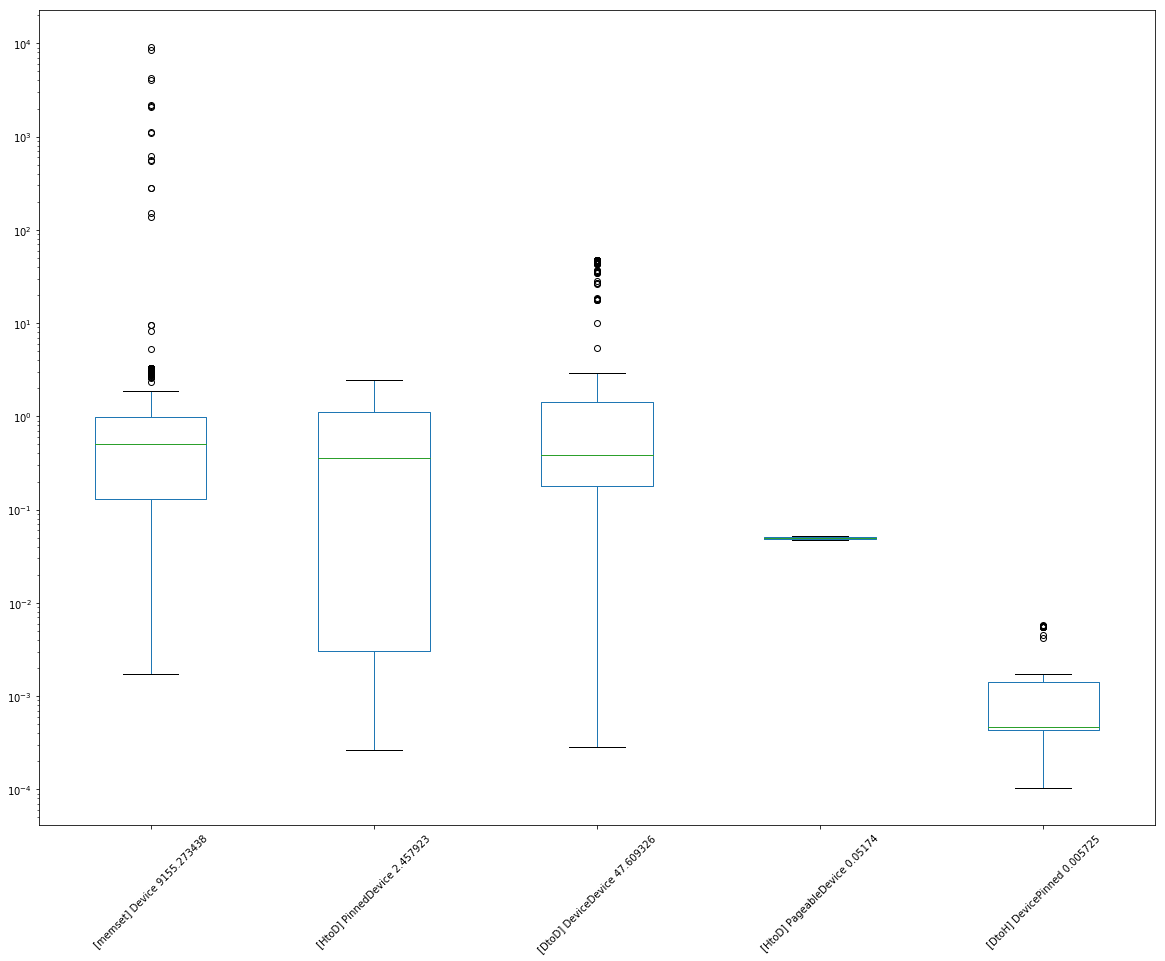

In [139]:
dataframe.plot.box(logy=True,rot=45)
plt.ylabel

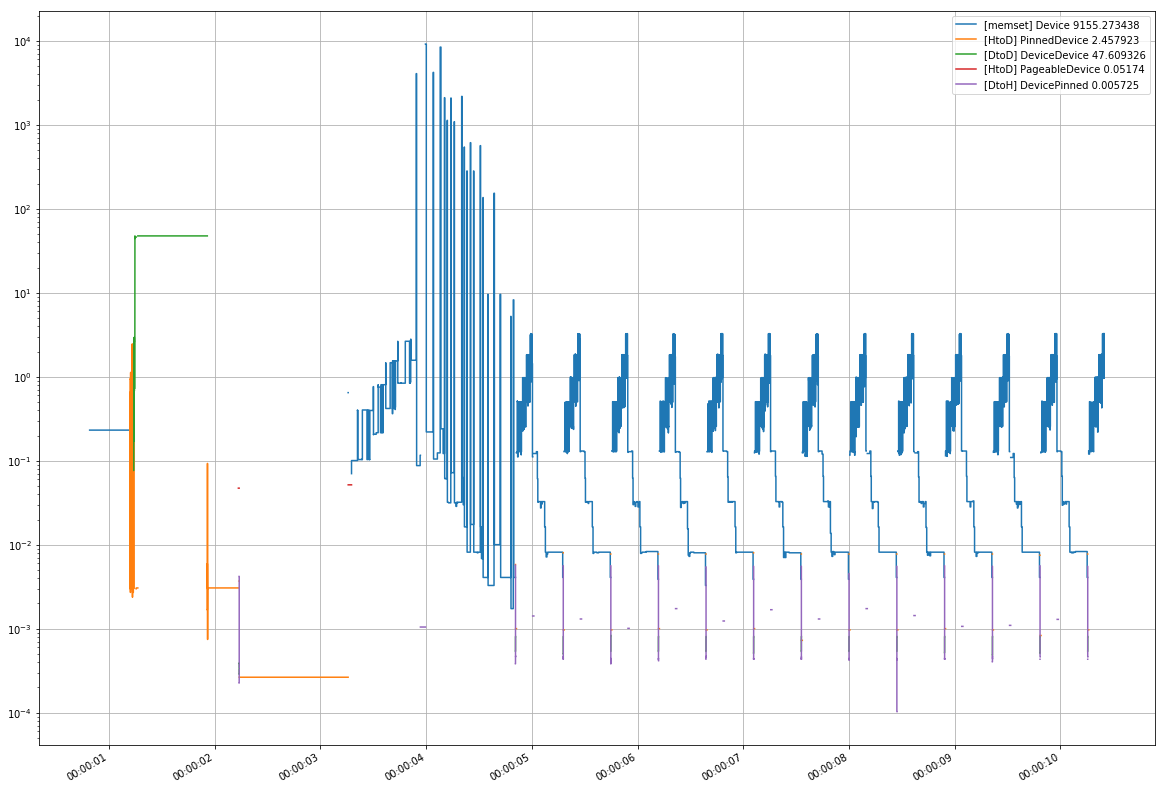

In [140]:
dataframe.plot(drawstyle="steps-post",logy=True,grid=True)

(327,) (11, 5)


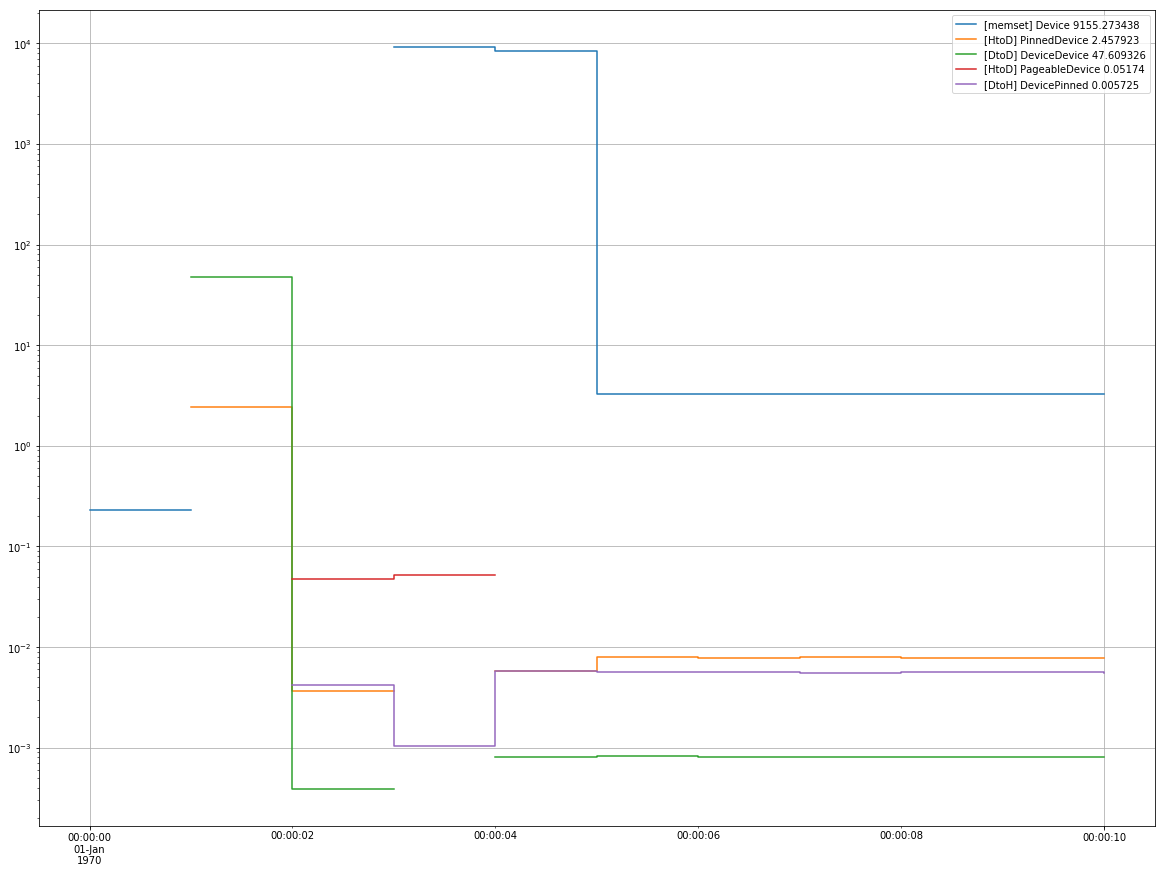

In [154]:
secunden = dataframe.resample("s").max()
print dataframes[1].Throughput.shape,secunden.shape
secunden.plot(drawstyle="steps-post",grid=True,logy=True)